# 模型融合

模型融合：将不同的模型进行融合，可能会收获意想不到的效果，往往模型相差越大且模型表现都不错的前提下，模型融合后结果会有大幅提升，
以下是模型融合的方式。
1. 平均：简单平均法、加权平均法
2. 投票：简单投票法、加权投票法
3. 综合：排序融合、log融合
4. stacking: 构建多层模型，并利用预测结果再拟合预测。
5. blending: 选取部分数据预测训练得到预测结果作为新特征，代入剩下的数据中预测。
6. boosting/bagging


## 读取数据

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd 
from tqdm import tqdm
from collections import defaultdict  

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
%matplotlib inline
plt.rc('font', family='SimHei', size=13)
import seaborn as sns

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgbm
from lightgbm.sklearn import LGBMClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss

import pickle as cPickle

In [2]:
# 通过调整数据类型，帮助我们减少数据在内存中占用的空间
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

train = reduce_mem_usage(pd.read_csv('./train_data_v1.csv'))
test = reduce_mem_usage(pd.read_csv('./test_data_v1.csv'))

train_y = train['isDefault']
train_X = train.drop(['isDefault'], axis=1)
test = test.drop(['isDefault'], axis=1)

feat_names = train_X.columns 
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)

Memory usage of dataframe is 940800128.00 MB
Memory usage after optimization is: 229600128.00 MB
Decreased by 75.6%
Memory usage of dataframe is 235200128.00 MB
Memory usage after optimization is: 57400128.00 MB
Decreased by 75.6%


## 1. 加权平均
简单加权平均：结果直接融合，求多个预测结果的平均值。pre1-pren分别是n组模型预测出来的结果，将其进行加权融
加权平均法：一般根据之前预测模型的准确率，进行加权融合，将准确性高的模型赋予更高的权重。

In [4]:
# 把lightGBM模型和nn模型加权平均后，结果从之前的0.7271提升到了0.7330，提升幅度很大。
import pandas as pd

r1 = pd.read_csv('../submission_0923_v1.csv')
r2 = pd.read_csv('../submission_nn_7270.csv')

sub = pd.DataFrame()
sub['id'] = r1.index
sub['isDefault'] = 0.5 * r1['isDefault'] + 0.5 * r2['isDefault']
sub.to_csv('../submission_0925_mean_v2.csv', index=False)

## 2. Voting投票机制

Voting即投票机制，分为软投票和硬投票两种，其原理采用少数服从多数的思想

In [6]:
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(train_X, train_y, test_size=0.2, random_state=2020)

In [ ]:
'''
硬投票：对多个模型直接进行投票，不区分模型结果的相对重要度，最终投票数最多的类为最终被预测的类。
'''
# 数据集划分
X_train_split, X_val, y_train_split, y_val = train_test_split(train_X, train_y, test_size=0.2)
train_data = lgbm.Dataset(X_train_split, label=y_train_split)
valid_data = lgbm.Dataset(X_val, label=y_val)

clf1 = SVC(C=0.1)
clf2 = RandomForestClassifier(n_estimators=5000, max_depth=8, min_samples_split=4,
                              min_samples_leaf=40,oob_score=True)
clf3 = LGBMClassifier(objective='binary',boosting_type='gbdt',learning_rate=0.05, n_estimators=10000, 
                      max_depth=7, num_leaves = 40, min_child_samples=30, 
                      subsample=0.9, subsample_freq=1,colsample_bytree=0.7,
                      reg_alpha=16, reg_lambda=30,num_threads=16)
 
# 硬投票
eclf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('lgb', clf3)],voting='hard')
for clf, label in zip([clf1, clf2, clf3, eclf], ['SVM', 'Random Forest', 'LightGBM', 'Ensemble']):
    scores = cross_val_score(clf, train_X, train_y, cv=5, scoring='roc_auc')
    print("AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    
# vclf = vclf.fit(train_X,train_y)
# print(vclf.predict(test))

In [ ]:
'''
软投票：和硬投票原理相同，增加了设置权重的功能，可以为不同模型设置不同权重，进而区别模型不同的重要度。
'''
clf1 = SVC(C=0.1, probability=True,verbose=100,n_jobs=-1)
clf2 = RandomForestClassifier(n_estimators=5000, max_depth=8, min_samples_split=4,
                              min_samples_leaf=40,oob_score=True,verbose=100,n_jobs=-1)
clf3 = LGBMClassifier(objective='binary',boosting_type='gbdt',learning_rate=0.05, n_estimators=5000, 
                      max_depth=7, num_leaves = 40, min_child_samples=30, 
                      subsample=0.9, subsample_freq=1,colsample_bytree=0.7,
                      reg_alpha=16, reg_lambda=30,num_threads=16,verbose=100,n_jobs=-1)
 
# 硬投票
eclf = VotingClassifier(estimators=[('svc', clf1), ('rf', clf2), ('lgb', clf3)],voting='soft', weights=[1,1,2])
for clf, label in zip([clf1, clf2, clf3, eclf], ['SVM', 'Random Forest', 'LightGBM', 'Ensemble']):
    scores = cross_val_score(clf, train_X, train_y, cv=5, scoring='roc_auc',verbose=100)
    print("AUC: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  ................................................................
[LibSVM]

### SVM模型

In [ ]:
#单组超参数情况，模型在训练集上训练，在校验集上的测试的测试性能
def fit_grid_point_Linear(C, train_X, train_y, X_val, y_val):
    SVC2 =  LinearSVC(C = C)
    SVC2 = SVC2.fit(train_X, train_y)

#   accuracy = SVC2.score(X_val, y_val)
    pred_val = SVC2.predict(X_val)
    auc = metrics.roc_auc_score(y_val, pred_val)
    
    print("C= {} : auc= {} ".format(C, auc))
    return auc

#SVM太慢，每次只调一个参数（这里只调C，penalty为‘l2'）
C_s = np.logspace(-1, 3, 4) # logspace(a,b,N)把10的a次方到10的b次方区间分成N份  

auc_scores = []
for i, one in enumerate(C_s):
    tmp = fit_grid_point_Linear(one, X_train_split, y_train_split, X_val, y_val)
    auc_scores.append(tmp)

x_axis = np.log10(C_s)
plt.plot(x_axis, np.array(auc_scores), 'b-')
    
plt.legend()
plt.xlabel('log(C)')                                                                                                      
plt.ylabel('accuracy')
plt.show()

以上超参数结果显示，C=1000时auc分数最高

## 随机森林模型

随机森林的超参会有很多：
Bagging参数：
1. 树的数目n_estimators

与决策树的共同的超参数：
1. max_depth（树的深度）或max_leaf_nodes（叶子结点的数目）；
2. min_samples_leaf（叶子结点的最小样本数）、min_samples_split（中间结点的最小样本树）、min_weight_fraction_leaf（叶子节点的样本权重占总权重的比例）
3. max_features（最大特征数目）。与决策树max_features通常越大模型性能越好不同，随机森林中max_features较小，每个基学习器之间的相关性更小，集成模型的性能可能反而会更好；

另外在随机森林中，由于学习每个基学习器只用了一部分样本，可用其余样本（包外样本）做校验，从而不必显式进行交叉验证。
设置参数oob_score=True

In [7]:
# 1.首先调优的参数 n_estimators
tuned_n_estimators = range(200,300,20)
accuracy_s = np.zeros(len(tuned_n_estimators))

#初始max_depth设为单棵树的max_depth，max_features比推荐值sqrt(144)=12略大,
for j, one in enumerate(tuned_n_estimators):
    RF2 = RandomForestClassifier(n_estimators=one, max_depth=10, max_features=20, min_samples_leaf=30,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(train_X, train_y)
    accuracy_s[j] = RF2.oob_score_

Text(0, 0.5, 'accuracy')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


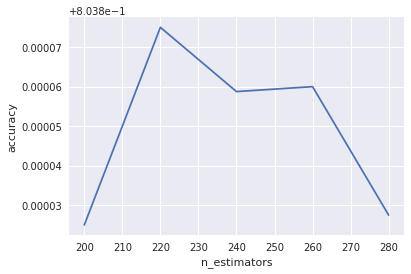

In [10]:
plt.plot(tuned_n_estimators, accuracy_s)
plt.xlabel('n_estimators')                                                                                                      
plt.ylabel('accuracy')

In [11]:
# 选择参数n_estimators=220
accuracy_s

array([0.803825  , 0.803875  , 0.80385875, 0.80386   , 0.8038275 ])

In [3]:
# 2.需要调优的参数 max_features
tuned_parameters = range(14,30,2)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 220, max_features =one_parameter,oob_score=True,n_jobs=4,random_state=33)
    RF2.fit(train_X, train_y)
    accuracy_s[j] = RF2.oob_score_ 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


[0.8034575  0.80364875 0.80329625 0.80345875 0.80345375 0.8033175
 0.80329875 0.80312125]


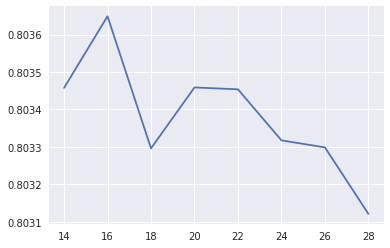

In [4]:
plt.plot(tuned_parameters, accuracy_s)
print(accuracy_s)

以上结果显示max_features=16时效果最好

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


[0.80444625 0.80363375 0.80369875]


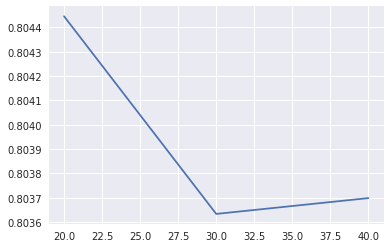

In [3]:
# 3.需要调优的参数 max_depth
tuned_parameters = range(20,50,10)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 220, max_features = 16, max_depth =one_parameter,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(train_X, train_y)
    accuracy_s[j] = RF2.oob_score_  
    
plt.plot(tuned_parameters, accuracy_s)
print(accuracy_s)

以上结果显示max_depth=20时效果最好，但是20是左侧边缘，所以继续调试

[0.8037175  0.80458875]


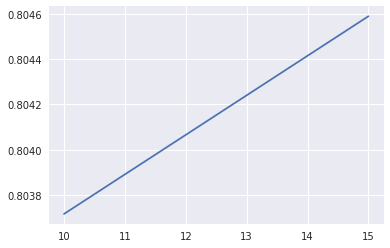

In [4]:
# 3.再次调优的参数 max_depth
tuned_parameters = range(10,20,5)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 220, max_features = 16, max_depth =one_parameter,oob_score=True,n_jobs=-1,random_state=33)
    RF2.fit(train_X, train_y)
    accuracy_s[j] = RF2.oob_score_  
    
plt.plot(tuned_parameters, accuracy_s)
print(accuracy_s)

以上结果显示max_depth=15时效果最好，选择15

0.80471
0.8045125
0.8046775
0.80469
0.80475625


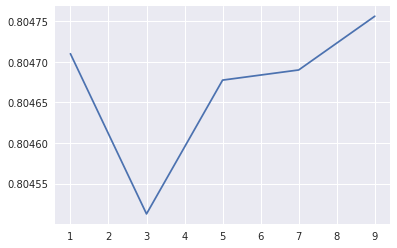

In [6]:
# 4. 需要调优的参数 min_samples_leaf
tuned_parameters = range(1,10,2)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators=220, max_features=16, max_depth=15, n_jobs=-1,
                                 min_samples_leaf = one_parameter, oob_score=True, random_state=33)
    RF2.fit(train_X, train_y)
    accuracy_s[j] = RF2.oob_score_ 
    print(accuracy_s[j])
plt.plot(tuned_parameters, accuracy_s)

0.80475875
0.80472
0.80467


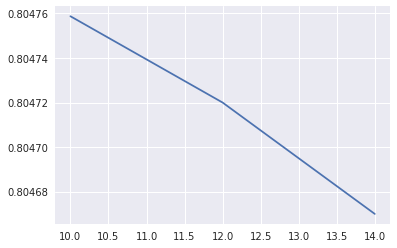

In [7]:
#需要调优的参数 min_samples_leaf
tuned_parameters = range(10,15,2)
accuracy_s = np.zeros(len(tuned_parameters))

for j, one_parameter in enumerate(tuned_parameters):
    RF2 = RandomForestClassifier(n_estimators = 220, max_features = 16, max_depth =16, n_jobs=-1,
                                 min_samples_leaf = one_parameter, oob_score=True, random_state=33)
    RF2.fit(train_X, train_y)
    accuracy_s[j] = RF2.oob_score_ 
    print(accuracy_s[j])
plt.plot(tuned_parameters, accuracy_s)

以上结果显示min_samples_leaf=9时，效果最好。最后用调试好的参数重新训练所有训练数据，生成模型，保存模型。

In [8]:
RF2 = RandomForestClassifier(n_estimators = 220, max_features = 16, max_depth =16, min_samples_leaf = 10,
                             n_jobs=-1,random_state=33)
RF2.fit(train_X, train_y)

ModuleNotFoundError: No module named 'cPickle'

In [10]:
# 显示特征重要性
import pickle as cPickle 
cPickle.dump(RF2, open("./model_randomForest.pkl", 'wb'))
df = pd.DataFrame({"columns":list(feat_names), "importance":list(RF2.feature_importances_.T)})
df = df.sort_values(by=['importance'],ascending=False)
df

,columns,importance
34,subGrade,6.188997e-02
12,interestRate,5.984198e-02
8,grade,4.143406e-02
49,grade_count,3.823504e-02
50,subGrade_count,3.477597e-02
...,...,...
145,purpose_13,9.022560e-07
127,homeOwnership_4,0.000000e+00
126,homeOwnership_3,0.000000e+00
27,policyCode,0.000000e+00


In [ ]:
### 随机森林的概率校准
# 诸如bagging 和 random forests（随机森林）的方法， 从基本模型的平均预测中可能难以将预测置于 0 和 1 附近，
# 因此对其结果输出做概率校准，得到的每类概率输出会更好
from sklearn.calibration import CalibratedClassifierCV

CalibratedRF = CalibratedClassifierCV(base_estimator=RF2, cv=5)
CalibratedRF.fit(train_X, train_y)

## XGBoost模型

In [ ]:
XGBoost的主要超参数包括：
1. 树的数目n_estimators 和 学习率 learning_rate
2. 树的最大深度max_depth
3. 叶子结点的最小样本数:min_child_weight
4. 每棵树的列采样比例：colsample_bytree
5. 每棵树的行采样比例：subsample
6. 正则化参数lambda_l1(reg_alpha), lambda_l2(reg_lambda)

对n_estimators，XGBoost学习的过程内嵌了cv，速度快。
其他参数用GridSearchCV。

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.sparse import csr_matrix
X_train = csr_matrix(X_train)

In [ ]:
## 第一步：学习率为0.1，粗调基学习器的数目n_estimators
MAX_ROUNDS = 10000

#直接调用xgboost内嵌的交叉验证（cv），可对连续的n_estimators参数进行快速交叉验证
#而GridSearchCV只能对有限个参数进行交叉验证
def get_n_estimators(params, X_train , y_train , early_stopping_rounds=10):
    xgb_params = params.copy()
    
    #直接调用xgboost，而非sklarn的wrapper类
    xgb_train = xgb.DMatrix(X_train, label = y_train)
        
    cvresult = xgb.cv(xgb_params, xgb_train, num_boost_round=MAX_ROUNDS, nfold=3,
             metrics='mlogloss', early_stopping_rounds=early_stopping_rounds,seed=3)
  
    cvresult.to_csv('1_nestimators.csv', index_label = 'n_estimators')
    
    #最佳参数n_estimators
    n_estimators = cvresult.shape[0]
    
         
    print('best n_estimators:' , n_estimators)
    print('best cv score:' , cvresult['test-mlogloss-mean'][n_estimators-1])
     
    return n_estimators

params = {'learning_rate': 0.1,
          #'n_estimators': 1000
          'min_child_weight': 1,
          'max_depth': 5,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'objective': 'multi:softprob',
          'num_class':9,
          'n_jobs': 4
         }

n_estimators_1 = get_n_estimators(params , X_train , y_train)

## 第二步：调整树的参数：max_depth & min_child_weight
这两个参数尽可能一起调，因为max_depth和min_child_weight都直接影响树模型的复杂度。
如果计算资源有限，也可类似坐标轴下降，先调其中一个，然后调另一个。
如果是分类任务，且不同类的样本数目不均衡，最好先调min_child_weight，以免max_depth对少数类样本过拟合。

 粗调，参数的步长为2。XGBoost的训练过程很慢，超参数调优无法很好进行。

In [ ]:
#max_depth 建议3-10， min_child_weight=1／sqrt(ratio_rare_event) =5.5
max_depth = range(5,10,2)
min_child_weight = range(1,10,1)
tuned_params = dict(max_depth=max_depth, min_child_weight=min_child_weight)

params = {'learning_rate': 0.1,
          'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          #'min_child_weight': 1,
          #'max_depth': 5,
          'subsample': 0.8,
          'colsample_bytree': 0.6,
          'objective': 'binary:logistic',
          'nthread': 4
         }

xgb_g = XGBClassifier(silent=False,  **params)
grid_search = GridSearchCV(xgb_g, param_grid=tuned_params, scoring='roc_auc',n_jobs=4, cv=5,verbose=10, refit = False)
grid_search.fit(X_train , y_train)

选择最佳参数max_depth=7, min_child_weight=9 

In [ ]:
## 最后，用树的最佳参数，再次调整学习率和基学习器的数目
params = {'num_class':9,
          'learning_rate': 0.05,
          #'n_estimators': 636,   #第一轮参数调整得到的n_estimators最优值
          'min_child_weight': 3,
          'max_depth': 5,
          'subsample': 0.8,
          'colsample_bytree': 0.7,
          'reg_lambda':2,
          'reg_alpha':1,
          'objective': 'binary:logistic',
          'nthread': 4
         }

n_estimators_2 = get_n_estimators(params , X_train , y_train)

## 3. 分类的Stacking\Blending融合：

stacking是一种分层模型集成框架。以两层为例，第一层由多个基学习器组成，其输入为原始训练集，第二层的模型则是以第一层基学习器的输出作为训练集进行再训练，从而得到完整的stacking模型, stacking两层模型都使用了全部的训练数据。



In [ ]:
''' 五折Stacking'''
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier,GradientBoostingClassifier

#模型融合中使用到的各个单模型
# clfs = [ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
#         GradientBoostingClassifier(learning_rate=0.05, subsample=0.9, max_depth=7, n_estimators=5000),
#         LGBMClassifier(objective='binary',boosting_type='gbdt',learning_rate=0.05, n_estimators=5000, 
#                       max_depth=7, num_leaves = 40, min_child_samples=30, 
#                       subsample=0.9, subsample_freq=1,colsample_bytree=0.7,
#                       reg_alpha=16, reg_lambda=30,num_threads=16,verbose=100)]
clfs = [
        RandomForestClassifier(n_estimators=220, max_features=16, max_depth=16, min_samples_leaf=10,
                              oob_score=True, random_state=2020),
        LGBMClassifier(objective='binary', boosting_type='gbdt',learning_rate=0.05, n_estimators=10000, 
                      max_depth=7, num_leaves=40, min_child_samples=30, 
                      subsample=0.9, subsample_freq=1, colsample_bytree=0.7,
                      reg_alpha=16, reg_lambda=30,num_threads=16,verbose=100)]

#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(train_X, train_y, test_size=0.2, random_state=2020)

dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_predict.shape[0], len(clfs)))

#5折stacking
n_splits = 5
skf = StratifiedKFold(n_splits)
skf = skf.split(X, y)

for j, clf in enumerate(clfs):
    #依次训练各个单模型
    dataset_blend_test_j = np.zeros((X_predict.shape[0], 5))
    for i, (train, test) in enumerate(skf):
        #5-Fold交叉训练，使用第i个部分作为预测，剩余的部分来训练模型，获得其预测的输出作为第i部分的新特征。
        X_train, y_train, X_test, y_test = X.iloc[train], y.iloc[train], X.iloc[test], y.iloc[test]
        clf.fit(X_train, y_train)
        y_submission = clf.predict_proba(X_test)[:, 1]
        dataset_blend_train[test, j] = y_submission
        dataset_blend_test_j[:, i] = clf.predict_proba(X_predict)[:, 1]
    #对于测试集，直接用这k个模型的预测值均值作为新的特征。
    dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_blend_test[:, j]))

clf = LogisticRegression(solver='lbfgs')
clf.fit(dataset_blend_train, y)
y_submission = clf.predict_proba(dataset_blend_test)[:, 1]

print("Val auc Score of Stacking: %f" % (roc_auc_score(y_predict, y_submission)))


Blending，其实和Stacking是一种类似的多层模型融合的形式

其主要思路是把原始的训练集先分成两部分，比如70%的数据作为新的训练集，剩下30%的数据作为测试集。
在第一层，我们在这70%的数据上训练多个模型，然后去预测那30%数据的label，同时也预测test集的label。
在第二层，我们就直接用这30%数据在第一层预测的结果做为新特征继续训练，然后用test集第一层预测的label做特征，用第二层训练的模型做进一步预测

其优点在于：
    1.比stacking简单（因为不用进行k次的交叉验证来获得stacker feature）
    2.避开了一个信息泄露问题：generlizers和stacker使用了不一样的数据集

缺点在于：
    1.使用了很少的数据（第二阶段的blender只使用training set10%的量）
    2.blender可能会过拟合
    3.stacking使用多次的交叉验证会比较稳健 '''



In [ ]:
'''Blending'''
#模型融合中使用到的各个单模型
clfs = [LogisticRegression(solver='lbfgs'),
        ExtraTreesClassifier(n_estimators=5, n_jobs=-1, criterion='entropy'),
        GradientBoostingClassifier(learning_rate=0.05, subsample=0.9, max_depth=7, n_estimators=5000),
        LGBMClassifier(objective='binary',boosting_type='gbdt',learning_rate=0.05, n_estimators=5000, 
                      max_depth=7, num_leaves = 40, min_child_samples=30, 
                      subsample=0.9, subsample_freq=1,colsample_bytree=0.7,
                      reg_alpha=16, reg_lambda=30,num_threads=16,verbose=100)]
 
#切分一部分数据作为测试集
X, X_predict, y, y_predict = train_test_split(train_X, train_y, test_size=0.2, random_state=2020)

#切分训练数据集为d1,d2两部分
X_d1, X_d2, y_d1, y_d2 = train_test_split(X, y, test_size=0.5, random_state=2020)
dataset_d1 = np.zeros((X_d2.shape[0], len(clfs)))
dataset_d2 = np.zeros((X_predict.shape[0], len(clfs)))
 
for j, clf in enumerate(clfs):
    #依次训练各个单模型
    clf.fit(X_d1, y_d1)
    y_submission = clf.predict_proba(X_d2)[:, 1]
    dataset_d1[:, j] = y_submission
    #对于测试集，直接用这k个模型的预测值作为新的特征。
    dataset_d2[:, j] = clf.predict_proba(X_predict)[:, 1]
    print("val auc Score: %f" % roc_auc_score(y_predict, dataset_d2[:, j]))

#融合使用的模型
clf = GradientBoostingClassifier(learning_rate=0.05, subsample=0.8, max_depth=7, n_estimators=3000)
clf.fit(dataset_d1, y_d2)
y_submission = clf.predict_proba(dataset_d2)[:, 1]
print("Val auc Score of Blending: %f" % (roc_auc_score(y_predict, y_submission)))

## 训练多个模型做融合

In [ ]:
def build_model_lr(x_train,y_train):
    reg_model = linear_model.LinearRegression()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_ridge(x_train,y_train):
    reg_model = linear_model.Ridge(alpha=0.8)#alphas=range(1,100,5)
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_lasso(x_train,y_train):
    reg_model = linear_model.LassoCV()
    reg_model.fit(x_train,y_train)
    return reg_model

def build_model_gbdt(x_train,y_train):
    estimator =GradientBoostingRegressor(loss='ls',subsample= 0.85,max_depth= 5,n_estimators = 100)
    param_grid = { 
            'learning_rate': [0.05,0.08,0.1,0.2],
            }
    gbdt = GridSearchCV(estimator, param_grid,cv=3)
    gbdt.fit(x_train,y_train)
    print(gbdt.best_params_)
    # print(gbdt.best_estimator_ )
    return gbdt

def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=120, learning_rate=0.08, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=5) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=63,n_estimators = 100)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm


## 划分数据集，并用多种方法训练和预测

In [ ]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

## Train and Predict
print('Predict LR...')
model_lr = build_model_lr(x_train,y_train)
val_lr = model_lr.predict(x_val)
subA_lr = model_lr.predict(X_test)

print('Predict Ridge...')
model_ridge = build_model_ridge(x_train,y_train)
val_ridge = model_ridge.predict(x_val)
subA_ridge = model_ridge.predict(X_test)

print('Predict Lasso...')
model_lasso = build_model_lasso(x_train,y_train)
val_lasso = model_lasso.predict(x_val)
subA_lasso = model_lasso.predict(X_test)

print('Predict GBDT...')
model_gbdt = build_model_gbdt(x_train,y_train)
val_gbdt = model_gbdt.predict(x_val)
subA_gbdt = model_gbdt.predict(X_test)

print('predict XGB...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
subA_xgb = model_xgb.predict(X_test)

print('predict lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
subA_lgb = model_lgb.predict(X_test)

## Stacking融合

In [ ]:
## Starking
## 第一层
train_lgb_pred = model_lgb.predict(x_train)
train_xgb_pred = model_xgb.predict(x_train)
train_gbdt_pred = model_gbdt.predict(x_train)

Strak_X_train = pd.DataFrame()
Strak_X_train['Method_1'] = train_lgb_pred
Strak_X_train['Method_2'] = train_xgb_pred
Strak_X_train['Method_3'] = train_gbdt_pred

Strak_X_val = pd.DataFrame()
Strak_X_val['Method_1'] = val_lgb
Strak_X_val['Method_2'] = val_xgb
Strak_X_val['Method_3'] = val_gbdt

Strak_X_test = pd.DataFrame()
Strak_X_test['Method_1'] = subA_lgb
Strak_X_test['Method_2'] = subA_xgb
Strak_X_test['Method_3'] = subA_gbdt

## level2-method 
model_lr_Stacking = build_model_lr(Strak_X_train,y_train)
## 训练集
train_pre_Stacking = model_lr_Stacking.predict(Strak_X_train)
print('AUC of Stacking-LR:', roc_auc_score(y_train,train_pre_Stacking))

## 验证集
val_pre_Stacking = model_lr_Stacking.predict(Strak_X_val)
print('AUC of Stacking-LR:', roc_auc_score(y_val,val_pre_Stacking))

## 预测集
print('Predict Stacking-LR...')
subA_Stacking = model_lr_Stacking.predict(Strak_X_test)

sub = pd.DataFrame()
sub['id'] = TestA_data.id
sub['isDefault'] = subA_Stacking
sub.to_csv('./submission_v2.csv',index=False)